# Simple Starter Notebook for;
## Cryptocurrency Closing Price Prediction Challenge


Can you predict the closing price for a cryptocurrency? 

The objective of this challenge is to create a machine learning model that will predict closing price for a crypto currency coing. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from google.colab import files

In [2]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [3]:
# check data shapes
train.shape, test.shape, ss.shape

((7772, 49), (6222, 48), (6222, 2))

In [4]:
# Preview train
train.head()

,id,asset_id,open,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_volume,percent_change_24h,market_cap_global,close
0,ID_322qz6,1,9422.849081,9428.490628,9422.849081,7.131986e+08,1.737635e+11,1689.0,817.0,55.0,105.0,61.0,271.0,3420.0,1671.0,11675867.0,39.0,1343.0,448.0,2237.0,124.0,330.0,331.0,2515.0,120.0,506133.0,1326610.0,1159677.0,8406185.0,281329.0,11681999.0,3.6,69.0,2.7,3.6,3.3,66.0,0.007118,1.0,606.0,2.0,1.0,1.0,2.0,5.0,4422.0,1.434516,2.818066e+11,9428.279323
1,ID_3239o9,1,7985.359278,7992.059917,7967.567267,4.004755e+08,1.426942e+11,920.0,544.0,20.0,531.0,103.0,533.0,1491.0,242.0,5917814.0,195.0,1070.0,671.0,3888.0,1.0,52.0,315.0,1100.0,23.0,1320.0,381117.0,1706376.0,3754815.0,80010.0,5924770.0,3.7,1.0,2.0,2.0,1.0,43.5,0.009419,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2159.0,-2.459507,2.126897e+11,7967.567267
2,ID_323J9k,1,49202.033778,49394.593518,49068.057046,3.017729e+09,9.166977e+11,1446.0,975.0,72.0,1152.0,187.0,905.0,9346.0,4013.0,47778746.0,104.0,2014.0,1099.0,11476.0,331.0,923.0,864.0,6786.0,442.0,9848462.0,5178557.0,2145663.0,25510267.0,5110490.0,47796942.0,3.7,22.0,3.1,3.0,3.3,65.5,0.013530,1.0,692.0,3.0,1.0,1.0,NaN,NaN,10602.0,4.942448,1.530712e+12,49120.738484
3,ID_323y5P,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,424.0,268.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285.0,NaN,NaN,NaN
4,ID_324kJH,1,10535.737119,10535.737119,10384.798216,1.150053e+09,1.921183e+11,1012.0,638.0,24.0,42.0,50.0,173.0,3262.0,1652.0,14422172.0,21.0,511.0,190.0,2284.0,86.0,280.0,443.0,2284.0,169.0,311017.0,1977833.0,731277.0,10964321.0,440730.0,14426405.0,3.7,22.0,4.7,3.8,4.4,83.0,0.010332,1.0,749.0,2.0,1.0,1.0,NaN,2.0,3996.0,2.609576,3.386925e+11,10384.798216


In [5]:
test.head()

,id,asset_id,open,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_volume,percent_change_24h,market_cap_global
0,ID_323Sn2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,56.0,2.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
1,ID_325SNW,1,11335.062188,11351.690956,11335.062188,1.064152e+09,2.101463e+11,1664.0,1045.0,64.0,213.0,51.0,274.0,6046.0,3034.0,23453171.0,119.0,2305.0,1367.0,6252.0,151.0,565.0,603.0,4553.0,174.0,2900568.0,1898920.0,2268741.0,14056214.0,2338771.0,23465365.0,3.7,39.0,3.2,3.4,2.8,65.5,0.004407,1.0,711.0,2.0,1.0,1.0,1.0,1.0,7245,-0.555698,3.631052e+11
2,ID_325uzE,1,6322.560756,6328.362354,6294.714484,1.516268e+09,1.153862e+11,397.0,255.0,11.0,72.0,30.0,112.0,2404.0,304.0,3831278.0,12.0,346.0,73.0,604.0,39.0,103.0,668.0,1406.0,188.0,29147.0,411178.0,873284.0,2389256.0,129448.0,3832828.0,3.7,2.0,3.0,3.0,3.4,65.5,0.024035,1.0,715.0,2.0,1.0,1.0,NaN,NaN,2702,1.689370,1.771075e+11
3,ID_328qCx,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,96.0,217.0,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225,NaN,NaN
4,ID_3293uJ,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,49.0,33.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,NaN,NaN


In [6]:
ss.head()

,id,close
0,ID_323Sn2,0
1,ID_325SNW,0
2,ID_325uzE,0
3,ID_328qCx,0
4,ID_3293uJ,0


# Let's look for missing values

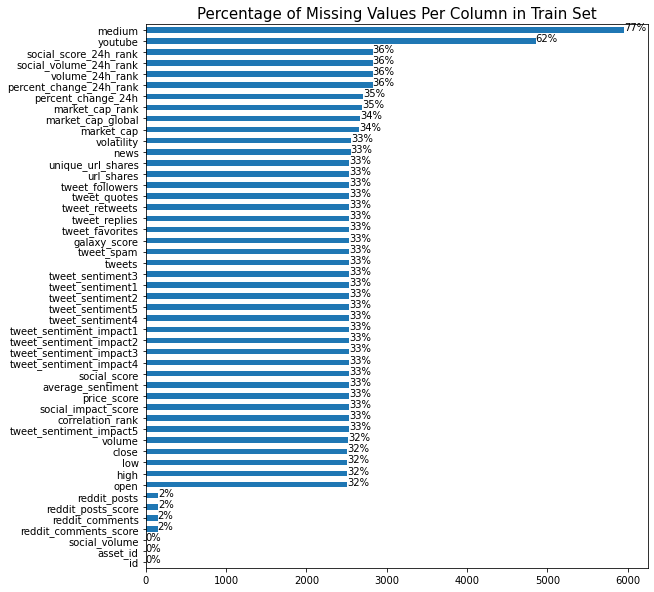

In [7]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

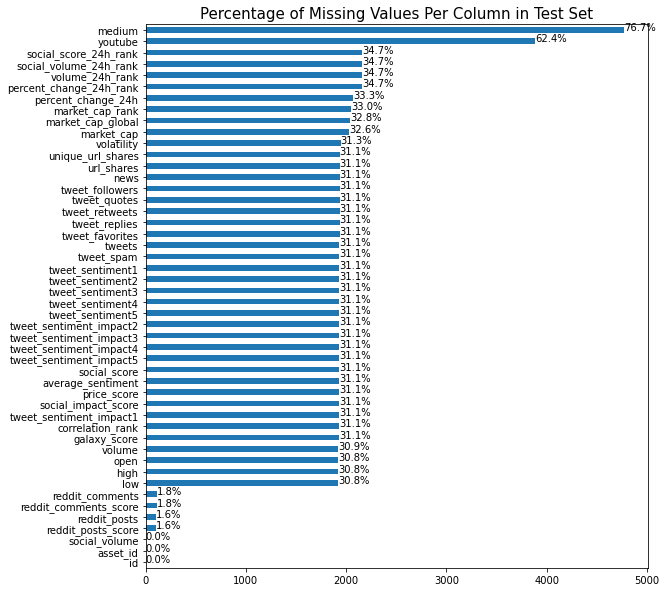

In [8]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [9]:
# fill missing values
train = train.fillna(0)
test = test.fillna(0)

In [10]:
cat_cols = train[['tweet_sentiment1', 'tweet_sentiment2',
       'tweet_sentiment3', 'tweet_sentiment4', 'tweet_sentiment5', 'market_cap_rank',
       'percent_change_24h_rank', 'volume_24h_rank', 'social_volume_24h_rank',
       'social_score_24h_rank',]]

float_cols = train[['price_score', 'social_impact_score', 'correlation_rank',
       'galaxy_score', 'percent_change_24h', 'market_cap_global', 'volatility'
       , 'average_sentiment', 'open', 'high', 'low', 'market_cap']]

num_cols = train[['volume','url_shares', 'unique_url_shares', 'reddit_posts', 'reddit_posts_score',
       'reddit_comments', 'reddit_comments_score', 'tweets', 'tweet_spam',
       'tweet_followers', 'tweet_quotes', 'tweet_retweets', 'tweet_replies',
       'tweet_favorites', 'tweet_sentiment_impact1', 'tweet_sentiment_impact2',
       'tweet_sentiment_impact3', 'tweet_sentiment_impact4',
       'tweet_sentiment_impact5', 'social_volume']]

for col in train.columns:
       if col in cat_cols:
              train[col] = train[col].astype('category')
              test[col] =test[col].astype('category')
       elif col in num_cols:
              train[col] = train[col].astype(int)
              test[col] =test[col].astype(int)
       elif col in float_cols:
              train[col] = train[col].astype(float)
              test[col] =test[col].astype(float)
              
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7772 entries, 0 to 7771
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       7772 non-null   object  
 1   asset_id                 7772 non-null   int64   
 2   open                     7772 non-null   float64 
 3   high                     7772 non-null   float64 
 4   low                      7772 non-null   float64 
 5   volume                   7772 non-null   int64   
 6   market_cap               7772 non-null   float64 
 7   url_shares               7772 non-null   int64   
 8   unique_url_shares        7772 non-null   int64   
 9   reddit_posts             7772 non-null   int64   
 10  reddit_posts_score       7772 non-null   int64   
 11  reddit_comments          7772 non-null   int64   
 12  reddit_comments_score    7772 non-null   int64   
 13  tweets                   7772 non-null   int64   
 14  tweet_sp

In [11]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

In [12]:
# Select main columns to be used in training
main_cols = train.columns.difference(['id', 'close'])
X = pd.get_dummies(train[main_cols])
y = train.close.astype(float)
tests = pd.get_dummies(test[main_cols])
scaler = StandardScaler()
X = scaler.fit_transform(X)
tests = scaler.fit_transform(tests)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=23)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5440, 8249), (5440,), (2332, 8249), (2332,))

In [23]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(10000, input_dim=8249, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00000001),
                 bias_regularizer=regularizers.l2(0.00001), activity_regularizer=regularizers.l2(0.00000001))),
	model.add(Dense(1, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00000001),
                 bias_regularizer=regularizers.l2(0.00001), activity_regularizer=regularizers.l2(0.00000001)))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [ ]:
# evaluate model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=1000, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=3)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/150
4/4 [==============================] - 26s 6s/step - loss: 294091808.0000
Epoch 2/150
4/4 [==============================] - 24s 6s/step - loss: 256187520.0000
Epoch 3/150
4/4 [==============================] - 24s 6s/step - loss: 213786857.6000
Epoch 4/150
4/4 [==============================] - 24s 6s/step - loss: 177984992.0000
Epoch 5/150
4/4 [==============================] - 24s 6s/step - loss: 185049916.8000
Epoch 6/150
4/4 [==============================] - 24s 6s/step - loss: 182233417.6000
Epoch 7/150
4/4 [==============================] - 24s 6s/step - loss: 175881360.0000
Epoch 8/150
4/4 [==============================] - 24s 6s/step - loss: 175093657.6000
Epoch 9/150
4/4 [==============================] - 24s 6s/step - loss: 169502982.4000
Epoch 10/150
4/4 [==============================] - 24s 6s/step - loss: 172545222.4000
Epoch 11/150
4/4 [==============================] - 24s 6s/step - loss: 164495830.4000
Epoch 12/150
4/4 [==============================] - 

In [ ]:
import math
math.sqrt(results.std())

224.44789336360827

In [ ]:
# Make prediction on the test se
xg_predict = cross_val_predict(pipelne, X_test, y_test, cv=3)
print('Mean Absolute Error:', mean_absolute_error(y_test, xg_predict))
print('Mean Squared Error:', mean_squared_error(y_test, xg_predict))
print('Root Mean Squared Error:', sqrt(mean_squared_error(y_test,  xg_predict)))
print('Mean Squared Log Error:',mean_squared_log_error(y_test, xg_predict))
print('R-Squared Score:', r2_score(y_test, xg_predict))

Epoch 1/100
190/190 [==============================] - 1s 2ms/step - loss: 276066960.7958
Epoch 2/100
190/190 [==============================] - 0s 2ms/step - loss: 269703817.5497
Epoch 3/100
190/190 [==============================] - 0s 2ms/step - loss: 180555557.4450
Epoch 4/100
190/190 [==============================] - 0s 2ms/step - loss: 139106323.5183
Epoch 5/100
190/190 [==============================] - 0s 2ms/step - loss: 81594836.2212
Epoch 6/100
190/190 [==============================] - 0s 2ms/step - loss: 59761596.6492
Epoch 7/100
190/190 [==============================] - 0s 2ms/step - loss: 35432941.1937
Epoch 8/100
190/190 [==============================] - 0s 2ms/step - loss: 33826201.6545
Epoch 9/100
190/190 [==============================] - 0s 2ms/step - loss: 34612206.8953
Epoch 10/100
190/190 [==============================] - 0s 2ms/step - loss: 35686304.8377
Epoch 11/100
190/190 [==============================] - 0s 2ms/step - loss: 28775015.8429
Epoch 12/100
19

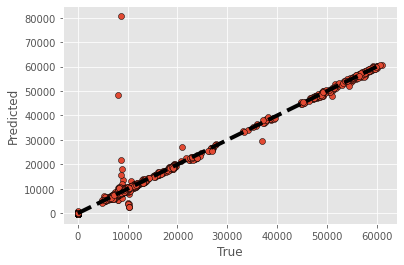

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_validate
test_val = cross_val_predict(pipeline, X_val, Y_val, cv= 5)

fig, ax = plt.subplots()
ax.scatter(Y_val, test_val, edgecolors=(0,0,0))
ax.plot([Y_val.min(), Y_val.max()], [Y_val.min(), Y_val.max()], 'k--', lw=4)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score(test_val, Y_val)

0.9790015367083241

Epoch 1/100
285/285 [==============================] - 1s 2ms/step - loss: 320345336.6154
Epoch 2/100
285/285 [==============================] - 1s 2ms/step - loss: 222029969.0070
Epoch 3/100
285/285 [==============================] - 1s 2ms/step - loss: 136488893.9860
Epoch 4/100
285/285 [==============================] - 1s 2ms/step - loss: 78748014.6993
Epoch 5/100
285/285 [==============================] - 1s 2ms/step - loss: 49354337.1189
Epoch 6/100
285/285 [==============================] - 1s 2ms/step - loss: 35695679.7168
Epoch 7/100
285/285 [==============================] - 1s 2ms/step - loss: 68195859.8916
Epoch 8/100
285/285 [==============================] - 1s 2ms/step - loss: 31981064.4615
Epoch 9/100
285/285 [==============================] - 1s 2ms/step - loss: 35988214.2080
Epoch 10/100
285/285 [==============================] - 1s 2ms/step - loss: 19743983.1014
Epoch 11/100
285/285 [==============================] - 1s 2ms/step - loss: 18716145.0557
Epoch 12/100
285

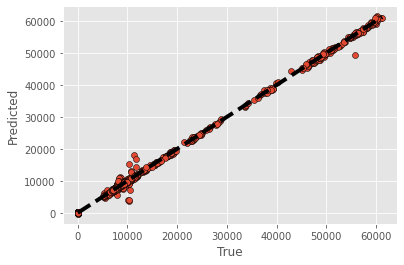

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_validate
val_pred = cross_val_predict(pipeline, X_test, Y_test, cv= 4)

fig, ax = plt.subplots()
ax.scatter(Y_test, val_pred, edgecolors=(0,0,0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score(val_pred, Y_test)

0.9987563248431708

758/758 [==============================] - 1s 955us/step


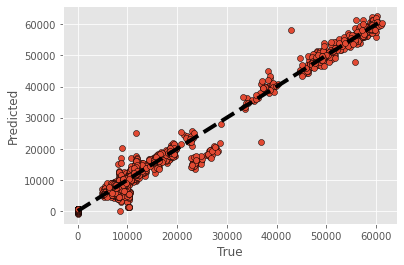

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_validate
val_pred = pipeline.predict(X_val_and_test)

fig, ax = plt.subplots()
ax.scatter(Y_val_and_test, val_pred, edgecolors=(0,0,0))
ax.plot([Y_val_and_test.min(), Y_val_and_test.max()], [Y_val_and_test.min(), Y_val_and_test.max()], 'k--', lw=4)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score(val_pred, Y_val_and_test)

0.9837953712864348

In [ ]:
# Instantiate model
#lm2 = LinearRegression()
# Fit Model
#lm2.fit(X_train, y_train)
# Predict
#y_pred = lm2.predict(X_test)

In [ ]:
# Make predictions in test set and prepare submission file
my_predictions = pipeline.predict(test[main_cols])
submission = pd.DataFrame()
submission['id'] = test.id
submission['close'] = my_predictions
submission.to_csv('Submission1.csv', index = False)

1245/1245 [==============================] - 2s 1ms/step


In [ ]:
submission.head()

,id,close
0,ID_323Sn2,534.042419
1,ID_325SNW,11629.844727
2,ID_325uzE,6561.279785
3,ID_328qCx,86.197090
4,ID_3293uJ,312.877319


In [ ]:
files.download('Submission1.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>